In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Path to spykes.py
import sys
sys.path.insert(0, '../spykes/')

# Set the style
def set_style():
    plt.rc("font", family="Bitstream Vera Sans")
    plt.style.use('./../spykes/mpl_styles/spykes.mplstyle')
set_style()

# Start by simulating a neuron
We will load real data later in this tutorial

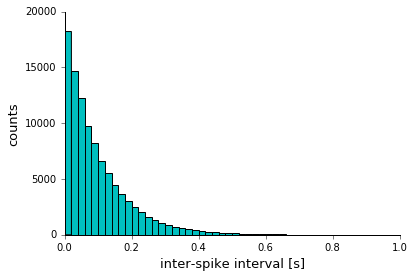

In [10]:
n_spikes = 100000
firing_rate = 10. # [spks/s]
av_inter_spk_interval = 1/firing_rate # average interspike interval [ms]

# Simulate
spike_times = np.cumsum(np.random.exponential(av_inter_spk_interval,n_spikes))

# Plot distribitution of inter-spike intervals
plt.hist(np.diff(spike_times), 50, color = 'c')
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')  
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('inter-spike interval [s]')
ax.set_ylabel('counts')
ax.get_yaxis().set_tick_params(direction='out')
ax.get_xaxis().set_tick_params(direction='out')
plt.show()

# Load spykes package

In [11]:
import spykes as spy

# Spyke class
### Instantiate neuron

In [12]:
neuron_id ='faker'   #choose name for neuron (not necessary)
neuron = spy.Spyke(spike_times, neuron_id)
neuron

# Spyke.firingrate
does it have the firing rate we simulated?


In [13]:
firing_rate = neuron.firingrate

print 'neuron %s has a firing rate of %.2f spks/s' % (neuron.name, neuron.firingrate)

neuron faker has a firing rate of 9.99 spks/s


# Spyke.get_psth
let's try a psth , we don't have an event....<br>
we can align it to spikes...


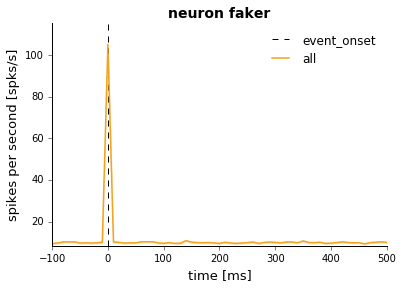

In [14]:
neuron.get_psth(spike_times[1000:10000]);

hmmm that makes sense <br>
let's simulate an event

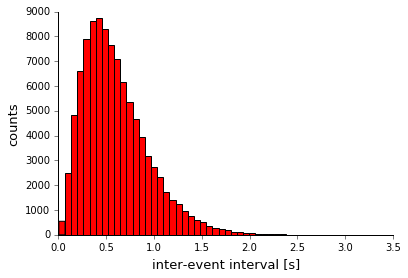

In [17]:
event_times = np.cumsum(np.random.gamma(3,0.2,100000))

# Plot distribitution of inter-event intervals
plt.hist(np.diff(event_times), 50, color = 'r')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_yaxis().set_tick_params(direction='out')
ax.get_xaxis().set_tick_params(direction='out')
ax.set_xlabel('inter-event interval [s]')
ax.set_ylabel('counts')
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')  
plt.show()

now let's look at the psth for this event

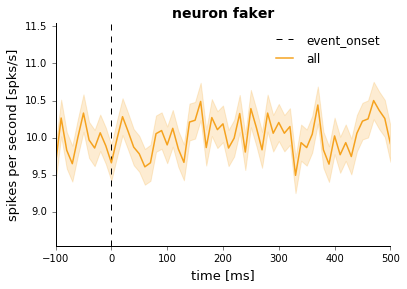

In [18]:
neuron.get_psth(event_times);

simulated neuron doesn't seem to be tuned to this independent event.... good

# Let's load some real data

In [19]:
# Packages for reading the data
import h5py
import deepdish as dd
import os
from skimage import io

# Load data
Monkey  = 'M1' #choose monkey
h5path = '/Volumes/JUICE/lab projects/V4_CNN/V4pydata/H5data/' + Monkey
fname = os.listdir(h5path)
fname = [session for session in fname if '.h5' in session]
thisfile = fname[0] #choose a session
dat = dd.io.load(h5path+'/'+ thisfile) #load

print 'loaded session: %s of monkey %s' % (thisfile[:-3], Monkey)
print "We have a dictionary with 2 fields: %s" % str(dat.keys())
print "and a total of %d neurons" % np.size(dat['spikes'].keys())

#let's get spikes and the list of neuron ids
spikes = dat['spikes']
neuron_list = dat['spikes'].keys()

loaded session: bucky090910 of monkey M1
We have a dictionary with 2 fields: ['eyes', 'spikes']
and a total of 142 neurons


In [20]:
#let's look at neuron number 50, for instance ;)
neuron_id = neuron_list[50]
spikes = dat['spikes'][neuron_id]

#instantiate neuron
neuron = spy.Spyke(spikes, name = neuron_id)

what's its firing rate?

In [21]:
print 'neuron %s has a firing rate of %.2f spks/s' % (neuron_id, neuron.firingrate)

neuron 3301 has a firing rate of 30.20 spks/s


now we want to plot a PSTH, let's see what are our options for events

In [22]:
print dat['eyes'][0].keys()

['in_sac_blink', 'imname', 'fix_offset', 'fix_offset_col', 'badfix', 'trial', 'out_sac_blink', 'out_sac_dur', 'col', 'fixation', 'out_sac_pkvel', 'in_sac_dur', 'impath', 'fix_onset', 'fix_offset_row', 'fix_onset_col', 'in_sac_pkvel', 'fix_onset_row', 'row']


let's use `fix_onset`, i.e. fixation onset

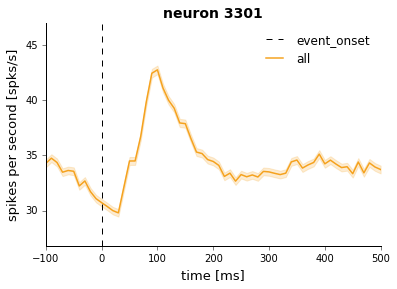

In [23]:
fix_onset_times = np.array([dat['eyes'][fix]['fix_onset'] for fix in dat['eyes']])
neuron.get_psth(fix_onset_times);

how about about a raster plot?

# Spyke.get_raster

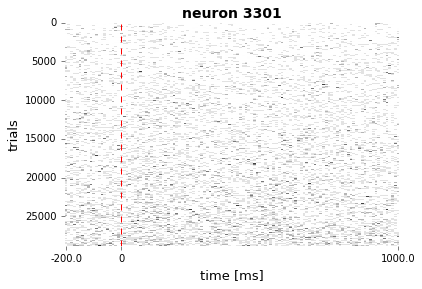

In [24]:
neuron.get_raster(fix_onset_times, window=[-200,1000]);

Let's restricting the trials to feature certain conditions <br>
First we get features

In [25]:
for_features = dat['eyes'][0].keys()
for i in ['imname','impath']: for_features.remove(i) 
features = {}
for feat in for_features:
    features[feat] = np.array([dat['eyes'][fix][feat] for fix in dat['eyes']])  
    
features['fix_duration'] = features['fix_offset']-features['fix_onset']
features['in_screen'] = np.all((features['col']>=1, features['col']<=1024, \
                                features['row']>=1, features['row']<=768), axis=0)
print features.keys()

['in_sac_blink', 'in_screen', 'fix_onset_row', 'fix_offset', 'fix_offset_col', 'out_sac_blink', 'out_sac_dur', 'fix_onset_col', 'fix_duration', 'trial', 'out_sac_pkvel', 'in_sac_dur', 'fix_onset', 'fixation', 'fix_offset_row', 'badfix', 'col', 'in_sac_pkvel', 'row']


Now we impose some restriction on those features that define which subset of trials we want in the PSTH.
For instance, let's look at fixations inside the screen vs outside the screen

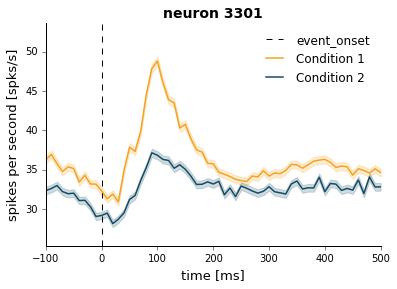

Condition 1: {'in_screen': [1]}; 14225 trials
Condition 2: {'in_screen': [0]}; 14591 trials


In [26]:
conditions = {}
conditions[0]= {}
conditions[0]['in_screen'] = [1]

conditions[1]= {}
conditions[1]['in_screen'] = [0]

neuron.get_psth(features['fix_onset'], features, conditions);

And we can add conditions:

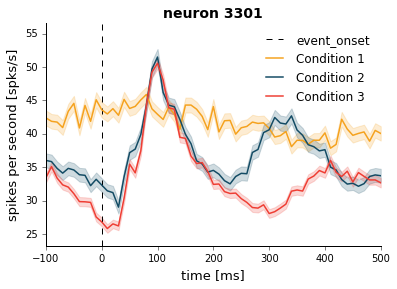

Condition 1: {'fix_duration': [0.0, 0.08], 'in_screen': [1]}; 3535 trials
Condition 2: {'fix_duration': [0.08, 0.2], 'in_screen': [1]}; 3362 trials
Condition 3: {'fix_duration': [0.2, 1.0], 'in_screen': [1]}; 6903 trials


In [27]:
conditions = {}
conditions[0]= {}
conditions[0]['in_screen'] = [1]
conditions[0]['fix_duration'] = [0.0, 0.08] # Fixation duration between [0, 80] ms

conditions[1]= {}
conditions[1]['in_screen'] = [1]
conditions[1]['fix_duration'] = [0.08, 0.2] # Fixation duration between [80, 200] ms

conditions[2]= {}
conditions[2]['in_screen'] = [1]
conditions[2]['fix_duration'] = [0.2, 1.0] # Fixation duration between [200, 1000] ms

neuron.get_psth(features['fix_onset'], features, conditions);

Let's look at a bigget time window

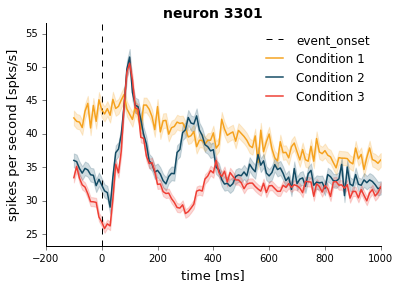

Condition 1: {'fix_duration': [0.0, 0.08], 'in_screen': [1]}; 3535 trials
Condition 2: {'fix_duration': [0.08, 0.2], 'in_screen': [1]}; 3362 trials
Condition 3: {'fix_duration': [0.2, 1.0], 'in_screen': [1]}; 6903 trials


In [28]:
neuron.get_psth(features['fix_onset'], \
                features, conditions, window = [-100,1000]);

Default binsizes are 10 ms, let's try with 50 ms

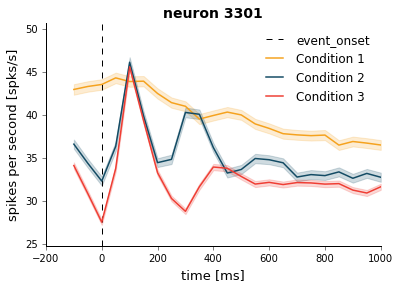

Condition 1: {'fix_duration': [0.0, 0.08], 'in_screen': [1]}; 3340 trials
Condition 2: {'fix_duration': [0.08, 0.2], 'in_screen': [1]}; 3362 trials
Condition 3: {'fix_duration': [0.2, 1.0], 'in_screen': [1]}; 6903 trials


In [29]:
neuron.get_psth(features['fix_onset'], features, conditions, \
                window = [-100,1000], binsize=50);

And some rasters for the same conditions

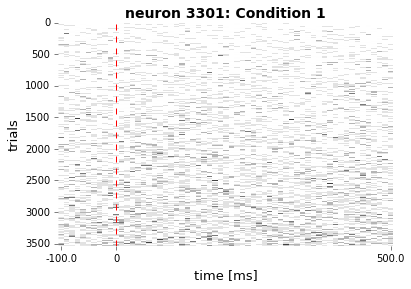

Condition 1: {'fix_duration': [0.0, 0.08], 'in_screen': [1]}


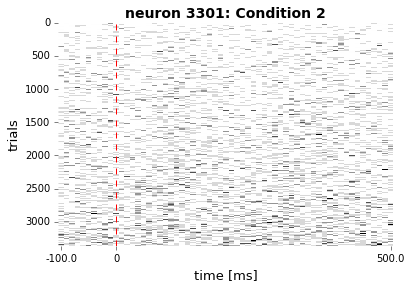

Condition 2: {'fix_duration': [0.08, 0.2], 'in_screen': [1]}


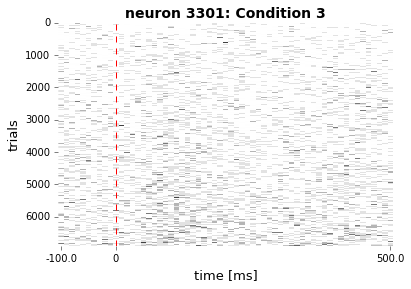

Condition 3: {'fix_duration': [0.2, 1.0], 'in_screen': [1]}


In [30]:
neuron.get_raster(features['fix_onset'], features, conditions);

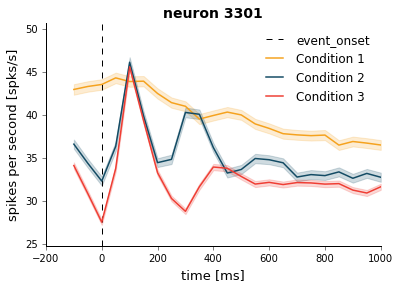

Condition 1: {'fix_duration': [0.0, 0.08], 'in_screen': [1]}; 3340 trials
Condition 2: {'fix_duration': [0.08, 0.2], 'in_screen': [1]}; 3362 trials
Condition 3: {'fix_duration': [0.2, 1.0], 'in_screen': [1]}; 6903 trials


In [31]:
psth = neuron.get_psth(features['fix_onset'], features, conditions, window = [-100,1000], binsize=50);

In [37]:
psth.keys()
psth['conditions']

{0: {'fix_duration': [0.0, 0.08], 'in_screen': [1]},
 1: {'fix_duration': [0.08, 0.2], 'in_screen': [1]},
 2: {'fix_duration': [0.2, 1.0], 'in_screen': [1]}}

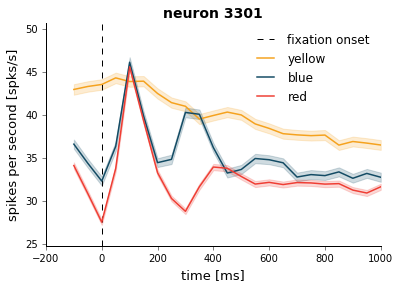

In [35]:
neuron.plot_psth(psth, event_name = 'fixation onset', \
                 condition_names=['yellow','blue','red'])

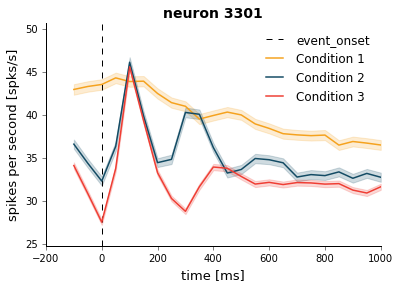

In [36]:
neuron.plot_psth(psth)